In [1]:
import os
from PIL import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
from tqdm import tqdm
import shutil
#---------------------------------------
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
#---------------------------------------
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
#---------------------------------------
import warnings
warnings.filterwarnings("ignore")

In [2]:
def move_files(file_paths, labels, train_dirs):
    with tqdm(total=len(file_paths), desc="Moving Files", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}") as pbar:
        for file_path, label in zip(file_paths, labels):
            if label == 0:  # bottle
                target_dir = train_dirs[0]
            elif label == 1:  # canister
                target_dir = train_dirs[1]
            elif label == 2:  # cans
                target_dir = train_dirs[2]
            elif label == 3:  # cardboard
                target_dir = train_dirs[3]
            elif label == 4:  # detergent
                target_dir = train_dirs[4]
            
            # Copy the file to the target directory
            shutil.copy(file_path, target_dir)
            pbar.update(1)  # Update progress bar by 1 step



def data_prep(input_dir, output_dir,i):

    # Define output directories for each class in the train set
    train_dir = os.path.join(output_dir, i)
    train_bottle_dir = os.path.join(train_dir, 'bottle')
    train_canister_dir = os.path.join(train_dir, 'canister')
    train_cans_dir = os.path.join(train_dir, 'cans')
    train_cardboard_dir = os.path.join(train_dir, 'cardboard')
    train_detergent_dir = os.path.join(train_dir, 'detergent')

    # Create the directories if they don't exist
    os.makedirs(train_bottle_dir, exist_ok=True)
    os.makedirs(train_canister_dir, exist_ok=True)
    os.makedirs(train_cans_dir, exist_ok=True)
    os.makedirs(train_cardboard_dir, exist_ok=True)
    os.makedirs(train_detergent_dir, exist_ok=True)

    # Collect images from subdirectories under the bottle class
    bottle_dir = os.path.join(input_dir, 'bottle')
    bottle_images = []
    for subdir in os.listdir(bottle_dir):
        subdir_path = os.path.join(bottle_dir, subdir)
        if os.path.isdir(subdir_path):  # Ensure it's a directory
            bottle_images.extend([os.path.join(subdir_path, img) for img in os.listdir(subdir_path)])

    # Repeat for other categories
    canister_dir = os.path.join(input_dir, 'canister/canister')
    canister_images = [os.path.join(canister_dir, img) for img in os.listdir(canister_dir) if os.path.isfile(os.path.join(canister_dir, img))]

    cans_dir = os.path.join(input_dir, 'cans/cans')
    cans_images = [os.path.join(cans_dir, img) for img in os.listdir(cans_dir) if os.path.isfile(os.path.join(cans_dir, img))]

    cardboard_dir = os.path.join(input_dir, 'cardboard')
    cardboard_images = []
    for subdir in os.listdir(cardboard_dir):
        subdir_path = os.path.join(cardboard_dir, subdir)
        if os.path.isdir(subdir_path):  # Ensure it's a directory
            cardboard_images.extend([os.path.join(subdir_path, img) for img in os.listdir(subdir_path)])

    detergent_dir = os.path.join(input_dir, 'detergent')
    detergent_images = []
    for subdir in os.listdir(detergent_dir):
        subdir_path = os.path.join(detergent_dir, subdir)
        if os.path.isdir(subdir_path):  # Ensure it's a directory
            detergent_images.extend([os.path.join(subdir_path, img) for img in os.listdir(subdir_path)])

    # Combine the data and create labels
    images = bottle_images + canister_images + cans_images + cardboard_images + detergent_images
    labels = [0] * len(bottle_images) + [1] * len(canister_images) + [2] * len(cans_images) + [3] * len(cardboard_images) + [4] * len(detergent_images)
    # Define train directories for each class
    train_dirs = [train_bottle_dir, train_canister_dir, train_cans_dir, train_cardboard_dir, train_detergent_dir]
    # Move training data
    print(f"Moving {i} data...")
    move_files(images, labels, train_dirs)

    print(f"{i} data successfully moved to train directories.")
    


# Function to move files to train folder with progress bar
def move_files(file_paths, labels, train_dirs):
    with tqdm(total=len(file_paths), desc="Moving Files", bar_format="{l_bar}{bar}| {n_fmt}/{total_fmt}") as pbar:
        for file_path, label in zip(file_paths, labels):
            if label == 0:  # bottle
                target_dir = train_dirs[0]
            elif label == 1:  # canister
                target_dir = train_dirs[1]
            elif label == 2:  # cans
                target_dir = train_dirs[2]
            elif label == 3:  # cardboard
                target_dir = train_dirs[3]
            elif label == 4:  # detergent
                target_dir = train_dirs[4]
            
            # Copy the file to the target directory
            shutil.copy(file_path, target_dir)
            pbar.update(1)  # Update progress bar by 1 step

In [3]:
data_prep("/kaggle/input/warp-waste-recycling-plant-dataset/Warp-C/train_crops","/kaggle/working/","train")

Moving train data...


Moving Files: 100%|██████████| 8823/8823

train data successfully moved to train directories.


In [4]:
data_prep("/kaggle/input/warp-waste-recycling-plant-dataset/Warp-C/test_crops","/kaggle/working/","test")

Moving test data...


Moving Files: 100%|██████████| 1551/1551

test data successfully moved to train directories.


In [5]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [6]:
train_df = train_df('/kaggle/working/train')
train_df

,Class Path,Class
0,/kaggle/working/train/bottle/POSAD_1_13-Sep_05...,bottle
1,/kaggle/working/train/bottle/POSAD_1_11-Sep_08...,bottle
2,/kaggle/working/train/bottle/POSAD_1_11-Sep_14...,bottle
3,/kaggle/working/train/bottle/POSAD_1_12-Sep_23...,bottle
4,/kaggle/working/train/bottle/Robo_25-Mar_11-49...,bottle
...,...,...
5126,/kaggle/working/train/detergent/POSAD_1_12-Sep...,detergent
5127,/kaggle/working/train/detergent/SPB_25-Mar_10-...,detergent
5128,/kaggle/working/train/detergent/prepared_data_...,detergent
5129,/kaggle/working/train/detergent/POSAD_1_11-Sep...,detergent


In [7]:
test_df = test_df('/kaggle/working/test')
test_df

,Class Path,Class
0,/kaggle/working/test/bottle/Monitoring_photo_t...,bottle
1,/kaggle/working/test/bottle/prepared_data_all_...,bottle
2,/kaggle/working/test/bottle/Monitoring_photo_2...,bottle
3,/kaggle/working/test/bottle/POSAD_1_11-Sep_16-...,bottle
4,/kaggle/working/test/bottle/Monitoring_photo_t...,bottle
...,...,...
964,/kaggle/working/test/detergent/Monitoring_phot...,detergent
965,/kaggle/working/test/detergent/Monitoring_phot...,detergent
966,/kaggle/working/test/detergent/Seldom_img_21-A...,detergent
967,/kaggle/working/test/detergent/Monitoring_phot...,detergent


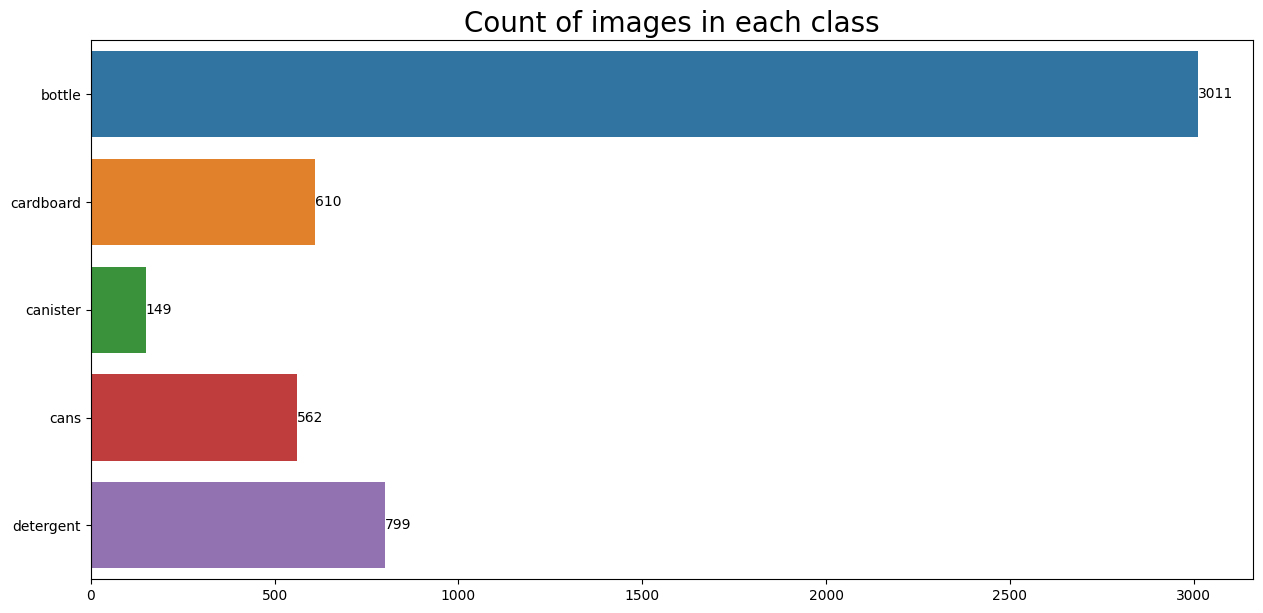

In [8]:
# Count of images in each class in train data
plt.figure(figsize=(15,7))
ax = sns.countplot(data=train_df , y=train_df['Class'])

plt.xlabel('')
plt.ylabel('')
plt.title('Count of images in each class', fontsize=20)
ax.bar_label(ax.containers[0])
plt.show()

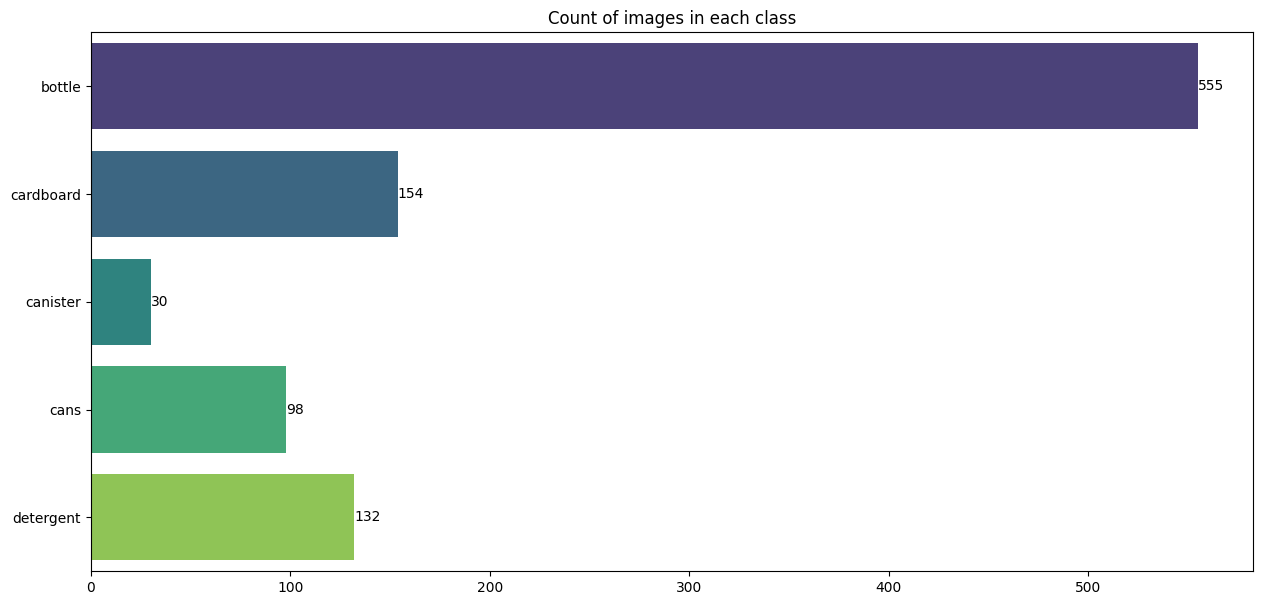

In [9]:
#Count each class in test data
plt.figure(figsize=(15, 7))
ax = sns.countplot(y=test_df['Class'], palette='viridis')

ax.set(xlabel='', ylabel='', title='Count of images in each class')
ax.bar_label(ax.containers[0])

plt.show()

In [10]:
# Filter out classes with only one sample
class_counts = test_df['Class'].value_counts()
classes_to_keep = class_counts[class_counts > 1].index
filtered_test_df = test_df[test_df['Class'].isin(classes_to_keep)]

# Now perform the split
valid_df, test_df = train_test_split(filtered_test_df, train_size=0.5, random_state=41, stratify=filtered_test_df['Class'])



In [11]:
valid_df

,Class Path,Class
701,/kaggle/working/test/cardboard/Monitoring_phot...,cardboard
765,/kaggle/working/test/cans/prepared_data_all_MG...,cans
598,/kaggle/working/test/cardboard/Monitoring_phot...,cardboard
192,/kaggle/working/test/bottle/Monitoring_photo_2...,bottle
357,/kaggle/working/test/bottle/prepared_data_all_...,bottle
...,...,...
571,/kaggle/working/test/cardboard/prepared_data_a...,cardboard
110,/kaggle/working/test/bottle/Monitoring_photo_t...,bottle
380,/kaggle/working/test/bottle/POSAD_1_12-Sep_09-...,bottle
384,/kaggle/working/test/bottle/Monitoring_photo_2...,bottle


In [12]:
test_df

,Class Path,Class
476,/kaggle/working/test/bottle/POSAD_1_12-Sep_22-...,bottle
915,/kaggle/working/test/detergent/POSAD_1_13-Sep_...,detergent
605,/kaggle/working/test/cardboard/prepared_data_a...,cardboard
620,/kaggle/working/test/cardboard/POSAD_1_11-Sep_...,cardboard
868,/kaggle/working/test/detergent/POSAD_1_13-Sep_...,detergent
...,...,...
720,/kaggle/working/test/canister/Monitoring_photo...,canister
179,/kaggle/working/test/bottle/POSAD_1_11-Sep_14-...,bottle
843,/kaggle/working/test/detergent/Monitoring_phot...,detergent
822,/kaggle/working/test/cans/Monitoring_photo_tes...,cans


In [13]:
# Initialize image data generator
datagen = ImageDataGenerator(rescale=1./255)

In [14]:
# Define model creation function
def create_model(img_shape):
    # Input layer
    inputs = Input(shape=img_shape)  # Shape: (None, 299, 299, 3)
    
    # Base model
    base_model = tf.keras.applications.Xception(
        include_top=False,
        weights="imagenet",
        input_tensor=None,  # We will not use input_tensor since we have an Input layer
        pooling='max'
    )
    
    # Connect the base model to the inputs
    x = base_model(inputs)  # Output shape will be (None, 2048)
    
    # Flatten Layer
    x = Flatten()(x)  # Output shape: (None, 2048)

    # First Dropout Layer
    x = Dropout(rate=0.3)(x)  # Output shape: (None, 2048)

    # First Dense Layer
    x = Dense(128, activation='relu')(x)  # Output shape: (None, 128)

    # Second Dropout Layer
    x = Dropout(rate=0.25)(x)  # Output shape: (None, 128)

    # Output Layer
    outputs = Dense(5, activation='sigmoid')(x)  # Output shape: (None, 5)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    model.compile(
        optimizer=Adamax(learning_rate=0.001),
        loss='categorical_crossentropy',
        metrics=['accuracy', Precision(), Recall()]
    )

    model.summary()  # Display model summary
    return model

In [15]:
# Placeholder lists for evaluation metrics
accuracy_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

Found 5131 validated image filenames belonging to 5 classes.
Found 484 validated image filenames belonging to 5 classes.
Found 485 validated image filenames belonging to 5 classes.
83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,397 (80.58 MB)

 Trainable params: 21,069,869 (80.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

Epoch 1/4


I0000 00:00:1730596381.692238      66 service.cc:145] XLA service 0x7d2240004e00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730596381.692293      66 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1730596411.547536      66 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


161/161 ━━━━━━━━━━━━━━━━━━━━ 129s 486ms/step - accuracy: 0.6647 - loss: 0.9721 - precision: 0.3687 - recall: 0.8894 - val_accuracy: 0.7273 - val_loss: 0.8555 - val_precision: 0.4352 - val_recall: 0.9360
Epoch 2/4
161/161 ━━━━━━━━━━━━━━━━━━━━ 53s 329ms/step - accuracy: 0.8953 - loss: 0.3044 - precision: 0.4279 - recall: 0.9903 - val_accuracy: 0.7128 - val_loss: 1.1867 - val_precision: 0.4204 - val_recall: 0.9112
Epoch 3/4
161/161 ━━━━━━━━━━━━━━━━━━━━ 53s 329ms/step - accuracy: 0.9589 - loss: 0.1331 - precision: 0.4565 - recall: 0.9969 - val_accuracy: 0.8512 - val_loss: 0.6047 - val_precision: 0.4410 - val_recall: 0.9876
Epoch 4/4
161/161 ━━━━━━━━━━━━━━━━━━━━ 53s 328ms/step - accuracy: 0.9766 - loss: 0.0725 - precision: 0.4760 - recall: 0.9998 - val_accuracy: 0.7831 - val_loss: 0.8787 - val_precision: 0.4479 - val_recall: 0.9504
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 146ms/step


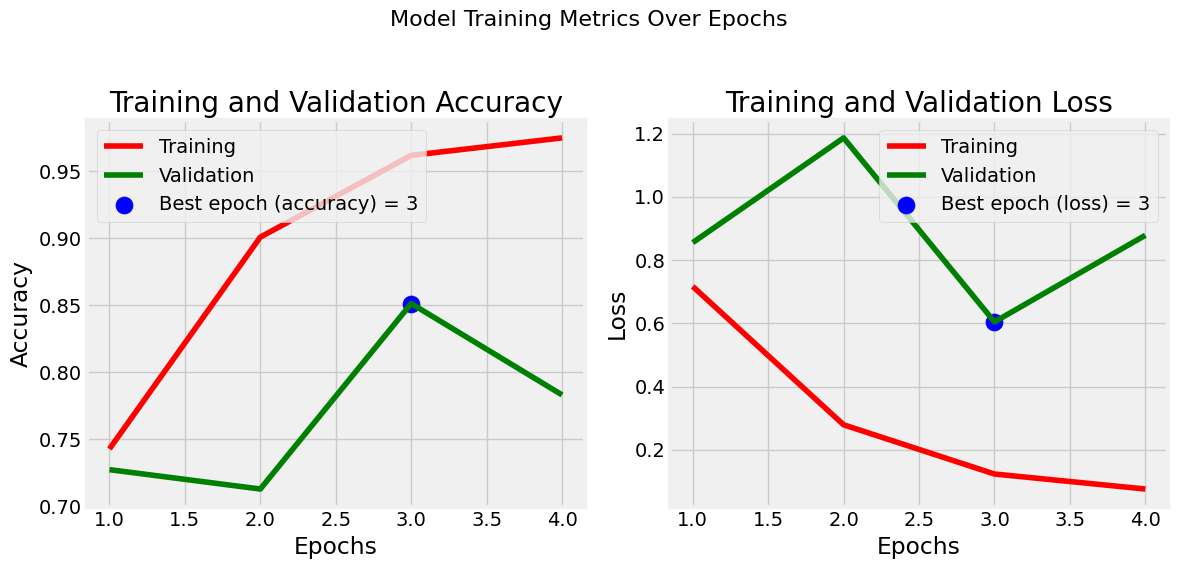

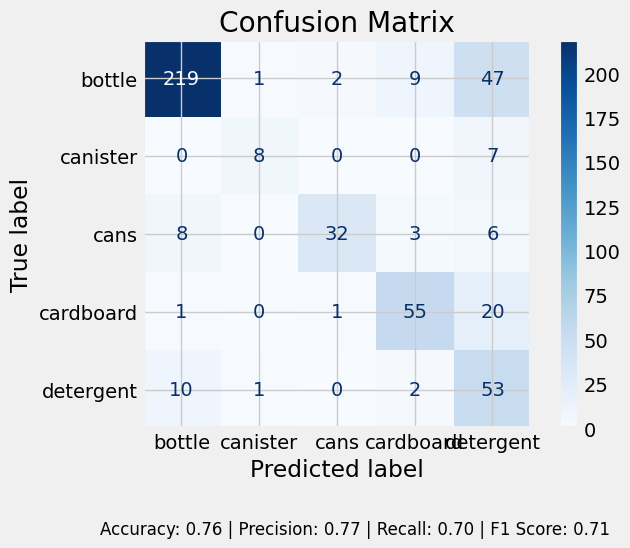

Found 5131 validated image filenames belonging to 5 classes.
Found 484 validated image filenames belonging to 5 classes.
Found 485 validated image filenames belonging to 5 classes.


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,397 (80.58 MB)

 Trainable params: 21,069,869 (80.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

Epoch 1/4
161/161 ━━━━━━━━━━━━━━━━━━━━ 104s 427ms/step - accuracy: 0.5847 - loss: 1.4812 - precision_1: 0.4102 - recall_1: 0.6969 - val_accuracy: 0.7686 - val_loss: 0.9995 - val_precision_1: 0.4658 - val_recall_1: 0.9008
Epoch 2/4
161/161 ━━━━━━━━━━━━━━━━━━━━ 53s 327ms/step - accuracy: 0.8378 - loss: 0.4561 - precision_1: 0.4700 - recall_1: 0.9540 - val_accuracy: 0.8182 - val_loss: 0.5177 - val_precision_1: 0.4612 - val_recall_1: 0.9711
Epoch 3/4
161/161 ━━━━━━━━━━━━━━━━━━━━ 53s 328ms/step - accuracy: 0.9504 - loss: 0.1581 - precision_1: 0.4758 - recall_1: 0.9951 - val_accuracy: 0.8223 - val_loss: 0.5835 - val_precision_1: 0.4648 - val_recall_1: 0.9814
Epoch 4/4
161/161 ━━━━━━━━━━━━━━━━━━━━ 53s 328ms/step - accuracy: 0.9743 - loss: 0.0781 - precision_1: 0.4949 - recall_1: 0.9992 - val_accuracy: 0.8554 - val_loss: 0.6022 - val_precision_1: 0.4673 - val_recall_1: 0.9607
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step


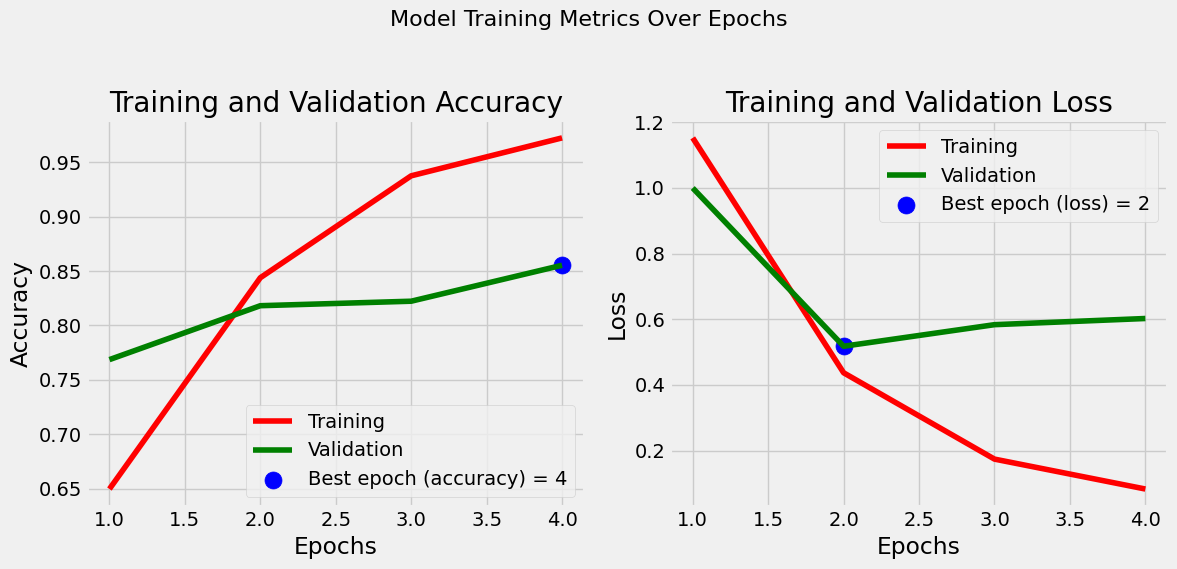

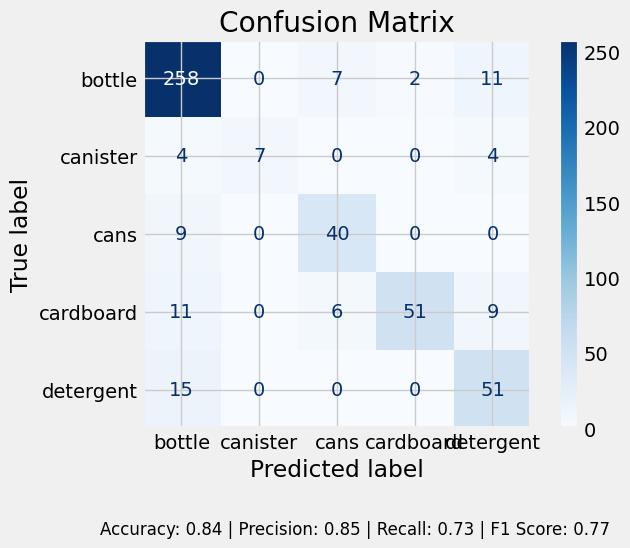

Found 5131 validated image filenames belonging to 5 classes.
Found 484 validated image filenames belonging to 5 classes.
Found 485 validated image filenames belonging to 5 classes.


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ xception (Functional)           │ (None, 2048)           │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,124,397 (80.58 MB)

 Trainable params: 21,069,869 (80.38 MB)

 Non-trainable params: 54,528 (213.00 KB)

Epoch 1/4
161/161 ━━━━━━━━━━━━━━━━━━━━ 104s 428ms/step - accuracy: 0.6823 - loss: 0.9834 - precision_2: 0.4138 - recall_2: 0.8634 - val_accuracy: 0.8079 - val_loss: 0.5275 - val_precision_2: 0.4396 - val_recall_2: 0.9628
Epoch 2/4
161/161 ━━━━━━━━━━━━━━━━━━━━ 53s 328ms/step - accuracy: 0.8988 - loss: 0.2868 - precision_2: 0.4728 - recall_2: 0.9866 - val_accuracy: 0.7893 - val_loss: 0.8201 - val_precision_2: 0.4470 - val_recall_2: 0.9318
Epoch 3/4
161/161 ━━━━━━━━━━━━━━━━━━━━ 53s 328ms/step - accuracy: 0.9668 - loss: 0.1028 - precision_2: 0.5225 - recall_2: 0.9982 - val_accuracy: 0.8182 - val_loss: 0.7429 - val_precision_2: 0.5508 - val_recall_2: 0.9752
Epoch 4/4
161/161 ━━━━━━━━━━━━━━━━━━━━ 53s 328ms/step - accuracy: 0.9757 - loss: 0.0736 - precision_2: 0.5697 - recall_2: 0.9992 - val_accuracy: 0.8368 - val_loss: 0.6368 - val_precision_2: 0.5293 - val_recall_2: 0.9711
31/31 ━━━━━━━━━━━━━━━━━━━━ 5s 107ms/step


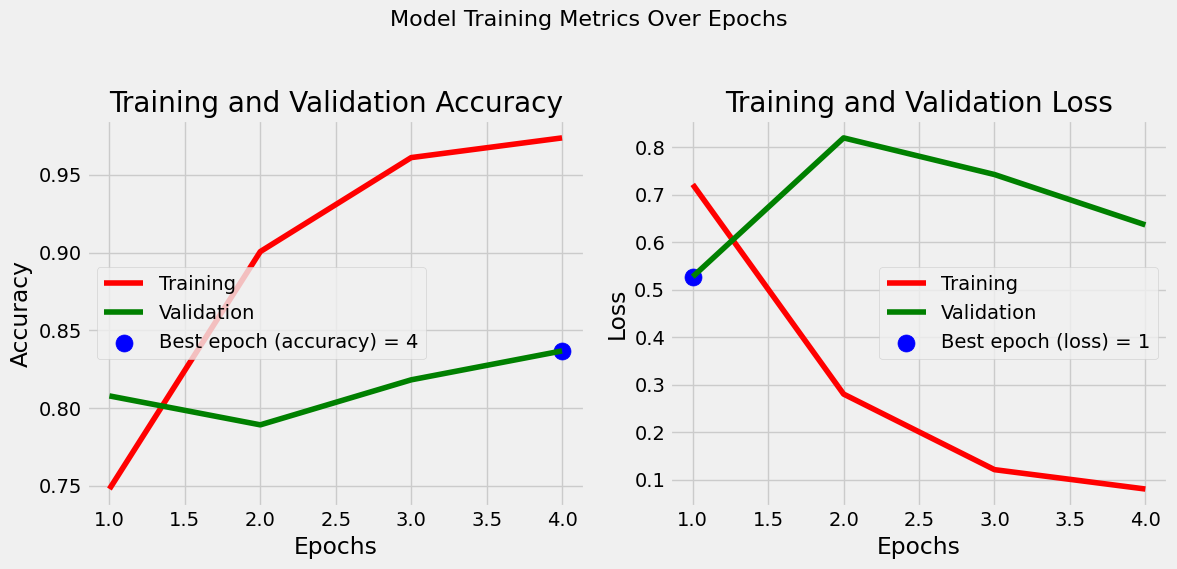

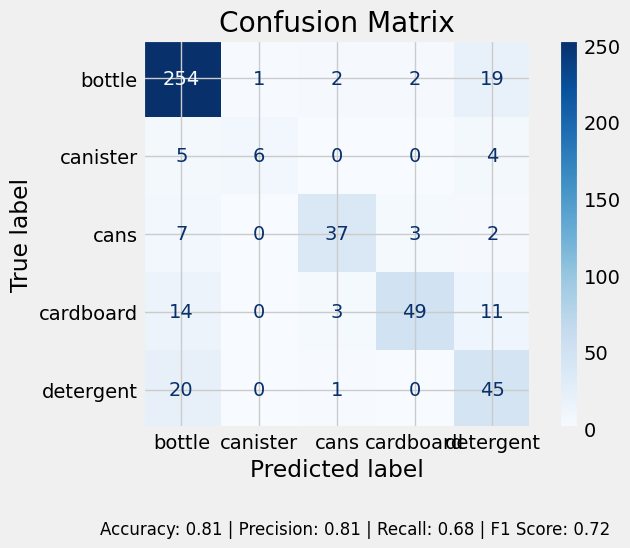

Cross-Validation Results:
Accuracy: 0.8007 ± 0.0339
Precision: 0.8082 ± 0.0356
Recall: 0.7016 ± 0.0213
F1 Score: 0.7301 ± 0.0252


In [16]:
# Prepare K-Fold Cross Validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)  # 5-fold CV
img_shape = (256,256,3)
# K-Fold Cross Validation Loop
for train_index, val_index in kf.split(train_df):
    # Split data into training and validation sets
    train_data = train_df.iloc[train_index]
    val_data = train_df.iloc[val_index]
    
    batch_size = 32
    img_size = (256, 256)

    _gen = ImageDataGenerator(rescale=1/255,
                              brightness_range=(0.8, 1.2))

    test_gen = ImageDataGenerator(rescale=1/255)


    train_gen = _gen.flow_from_dataframe(train_df, x_col='Class Path',
                                      y_col='Class', batch_size=batch_size,
                                      target_size=img_size)

    valid_gen = _gen.flow_from_dataframe(valid_df, x_col='Class Path',
                                         y_col='Class', batch_size=batch_size,
                                         target_size=img_size)

    test_gen = test_gen.flow_from_dataframe(test_df, x_col='Class Path',
                                      y_col='Class', batch_size=16,
                                      target_size=img_size, shuffle=False)

    # Build and train model
    model = create_model(img_shape)
    history = model.fit(train_gen, validation_data=valid_gen, epochs=4,shuffle= False)
    
    
    # Test veri setindeki gerçek etiketleri ve tahminleri alın
    y_true = test_gen.classes  # test_gen, test veri kümesi için kullanılan generator olmalı
    y_pred = model.predict(test_gen)
    y_pred_classes = np.argmax(y_pred, axis=1)  # Tahminleri sınıf etiketlerine çevir

    try:
        
        training_accuracy = history.history['accuracy']
        validation_accuracy = history.history['val_accuracy']
        training_loss = history.history['loss']
        validation_loss = history.history['val_loss']

        # Find best epoch metrics
        best_epoch_loss_index = np.argmin(validation_loss)
        best_validation_loss = validation_loss[best_epoch_loss_index]
        best_epoch_accuracy_index = np.argmax(validation_accuracy)
        best_training_accuracy = validation_accuracy[best_epoch_accuracy_index]

        # Prepare epoch numbers for plotting
        epochs = np.arange(1, len(training_accuracy) + 1)
        loss_label = f'Best epoch (loss) = {best_epoch_loss_index + 1}'
        accuracy_label = f'Best epoch (accuracy) = {best_epoch_accuracy_index + 1}'

        # Function for plotting training metrics
        def plot_training_metrics(epochs, training_metrics, validation_metrics, title, xlabel, ylabel, best_index, best_value, best_label):
            plt.plot(epochs, training_metrics, 'r', label='Training')
            plt.plot(epochs, validation_metrics, 'g', label='Validation')
            plt.scatter(best_index + 1, best_value, s=150, c='blue', label=best_label)
            plt.title(title)
            plt.xlabel(xlabel)
            plt.ylabel(ylabel)
            plt.legend()
            plt.grid(True)

        # Plotting metrics
        plt.figure(figsize=(12, 6))
        plt.style.use('fivethirtyeight')

        # Accuracy Plot
        plt.subplot(1, 2, 1)
        plot_training_metrics(epochs, training_accuracy, validation_accuracy,
                              'Training and Validation Accuracy', 'Epochs', 'Accuracy',
                              best_epoch_accuracy_index, best_training_accuracy, accuracy_label)

        # Loss Plot
        plt.subplot(1, 2, 2)
        plot_training_metrics(epochs, training_loss, validation_loss,
                              'Training and Validation Loss', 'Epochs', 'Loss',
                              best_epoch_loss_index, best_validation_loss, loss_label)

        plt.suptitle('Model Training Metrics Over Epochs', fontsize=16)
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to fit suptitle
        plt.show()

        # Confusion matrix oluşturma
        cm = confusion_matrix(y_true, y_pred_classes)

        # Confusion matrix'in görselleştirilmesi
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_gen.class_indices.keys())
        disp.plot(cmap='Blues')

        # Metrics hesaplama
        accuracy = accuracy_score(y_true, y_pred_classes)
        precision = precision_score(y_true, y_pred_classes, average='macro')
        recall = recall_score(y_true, y_pred_classes, average='macro')
        f1 = f1_score(y_true, y_pred_classes, average='macro')
        
        # Append the current metrics to the arrays
        accuracy_scores.append(accuracy)
        precision_scores.append(precision)
        recall_scores.append(recall)
        f1_scores.append(f1)

        # Display metrics below the confusion matrix
        plt.title("Confusion Matrix")
        plt.figtext(0.5, -0.15, f"Accuracy: {accuracy:.2f} | Precision: {precision:.2f} | Recall: {recall:.2f} | F1 Score: {f1:.2f}", ha="center", fontsize=12, color="black")

        plt.show()
    except ValueError as e:
        print(f"Error calculating metrics: {e}")

# Print cross-validation metrics
print("Cross-Validation Results:")
print(f"Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f} ± {np.std(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f} ± {np.std(recall_scores):.4f}")
print(f"F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")